- Using pre-trained resnet50
- 101->128
- Freeze all base resnet weights except BN
- BCE
- Adam 0.01 Batch Size 32
- Adam 0.005 Batch Size 16
- Adam 0.001 Batch Size 16

# Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gc
import glob
import os

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras import layers
from keras.utils.data_utils import get_file
from keras.layers.merge import concatenate
from keras.layers import SpatialDropout2D
from keras.losses import binary_crossentropy
from keras.models import Model, load_model, save_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add,  MaxPooling2D
from keras.layers import Conv2D, Conv2DTranspose, Lambda, Concatenate, UpSampling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
# from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


In [3]:
keras.__version__

'2.2.2'

In [4]:
tf.__version__

'1.10.1'

# Define SaltParser

In [5]:
class SaltParser(object):

    '''
    Parser for Salt Competition.
    '''

    def __init__(self, data_src,img_size_ori, img_size_target):

        self.data_src = data_src
        self.img_size_ori = img_size_ori
        self.img_size_target = img_size_target
        
        self.train_df = None
        self.test_df = None

        self.X_train = []
        self.y_train = []
        self.X_test = []
        

    def load_csv_data(self):
        
        '''
        Initialize processing by loading .csv files.
        After loading, train_df and test_df will have column 'id' for each unique image id
        and 'z' for depth
        '''

        train_df = pd.read_csv(f'{self.data_src}train.csv', usecols=[0], index_col='id')
        depths_df = pd.read_csv(f'{self.data_src}depths.csv', index_col='id')
        self.train_df = train_df.join(depths_df)
        self.test_df = depths_df[~depths_df.index.isin(train_df.index)]

        return

    
    def load_img_data(self):
        
        '''
        Load images and masks from training set. Can only be executed after load_csv_data()
        
        # Returns:
            self.X_train: np.array of training images
            self.y_train: np.array of training masks
            self.X_test: np.array of test images
        '''

        print("Loading training images...")
        self.X_train = [np.array(cv2.imread(f"{self.data_src}train/images/{idx}.png", 0)) for idx in tqdm_notebook(self.train_df.index)]
        self.X_train = np.expand_dims(self.X_train, -1)
        print(f'X_train shape: {self.X_train.shape}')
        print(f'X_train - min: {np.min(self.X_train)}, max: {np.max(self.X_train)}')
        
        print("\n\nLoading training masks...")
        self.y_train = [np.array(cv2.imread(f"{self.data_src}train/masks/{idx}.png", 0)) for idx in tqdm_notebook(self.train_df.index)]
        self.y_train = np.expand_dims(self.y_train, -1)
        print(f'y_train shape: {self.y_train.shape}')
        print(f'y_train - min: {np.min(self.y_train)}, max: {np.max(self.y_train)}')

        print("\n\nLoading test images...")
        self.X_test = [np.array(cv2.imread(f"{self.data_src}test/images/{idx}.png", 0)) for idx in tqdm_notebook(self.test_df.index)]
        self.X_test = np.expand_dims(self.X_test, -1)  
        print(f'X_test shape: {self.X_test.shape}')
        print(f'X_test - min: {np.min(self.X_test)}, max: {np.max(self.X_test)}')

        return self.X_train, self.y_train, self.X_test
        return self.X_train, self.y_train
    
    
    def process_img(self, data, normalized=False, image_resized_size=None, padding=None):
        data_proc = data
        
        if normalized:
            data = np.repeat(data,3,axis=3)
            data_proc = preprocess_input(data)
            
        data_proc_list = []
        
        for i in tqdm_notebook(range(data_proc.shape[0])):
            img_tmp = data_proc[i,:,:,0]

            if image_resized_size:
                img_tmp = cv2.resize(img_tmp, image_resized_size)

            if padding:
                img_tmp = cv2.copyMakeBorder(img_tmp, padding, padding, padding, padding,
                                             cv2.BORDER_REFLECT_101)
            data_proc_list.append(img_tmp)
            
        data_proc = np.expand_dims(data_proc_list, -1)          
            
        print(f'Processed data shape: {data_proc.shape}')
        print(f'Processed data - min: {np.min(data_proc)}, max: {np.max(data_proc)}')
        
        return data_proc
    

    def compute_coverage(self):
        
        '''
        Compute salt coverage of each mask. This will serve as a basis for 
        stratified split between training and validation sets.
        
        # Returns:
            self.train_df: training DF containing coverage information.
        '''

        print('Compute mask coverage for each observation.')
        self.train_df['coverage'] = np.mean(self.y_train / 255., axis=(1, 2))
        self.train_df["coverage_class"] = self.train_df.coverage.apply(lambda val: np.int(np.ceil(val*10)))
        
        return self.train_df

    def predictions_rle_encode(self, y_pred_test, confidence_threshold_best):
        
        '''
        Run Length Encoding of predictions.
        This is needed for submission output.
        
        # Arguments:
            y_pred_test: model predictions
            confidence_threshold_best: confidence threshold, according to which
                masks are set to 1/0.
        # Returns:
            y_test_pred_rle: RLEncoded predictions.
        '''

        # Remove padding
#         print('Remove padding from images.')
#         y_pred_test = y_pred_test[:, 11:-11, 11:-11, 0]
            
        # Resize back to original size
        y_pred_test = np.asarray([cv2.resize(x, self.img_size_ori) for x in y_pred_test])

        assert y_pred_test.shape == (18000, 101, 101), '\
        Test predictions shape must be equal to (18000, 101, 101).'

        print('Test predictions shape: {}'.format(y_pred_test.shape))

        # Perform mask predictions binarization and RLEncoding. 
        y_test_pred_rle = {idx:
                           rle_encode(y_pred_test[i] > confidence_threshold_best)
                           for i, idx in enumerate(
                               tqdm_notebook(self.test_df.index.values))}

        return y_test_pred_rle

    def generate_submission(self, y_test_pred_rle):
        
        '''
        Submission generation based on encoded model predictions.
        
        # Arguments:
            y_test_pred_rle: RLEncoded predictions.
        # Returns:
            submission: generated submission.
        '''

        submission = pd.DataFrame.from_dict(y_test_pred_rle, orient='index')
        submission.index.names = ['id']
        submission.columns = ['rle_mask']

        return submission

## Define helper functions

In [6]:
# Quick RLEncoding needed for submission generation.
# Source: another kernel, thanks!
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Initialize parameters

In [7]:
img_size_ori = 101
img_size_target = 128

salt_parser = SaltParser(data_src='data/salt/', 
                         img_size_ori=(img_size_ori, img_size_ori), 
                         img_size_target=(img_size_target, img_size_target))

## Initialize and load data

In [8]:
salt_parser.load_csv_data()
X_train, y_train, X_test = salt_parser.load_img_data()

Loading training images...



X_train shape: (4000, 101, 101, 1)
X_train - min: 0, max: 255


Loading training masks...



y_train shape: (4000, 101, 101, 1)
y_train - min: 0, max: 255


Loading test images...



X_test shape: (18000, 101, 101, 1)
X_test - min: 0, max: 255


## Salt coverage and depth

In [9]:
train_df = salt_parser.compute_coverage()

Compute mask coverage for each observation.


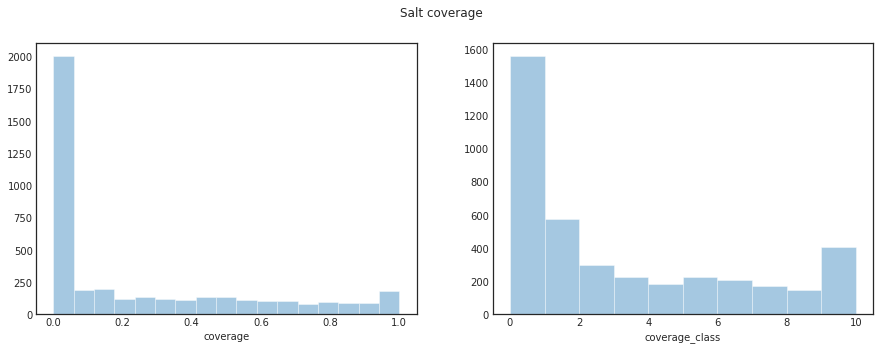

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.show()

Text(0.5, 1.0, 'Depth distribution')

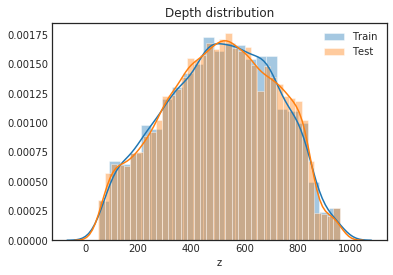

In [11]:
sns.distplot(salt_parser.train_df.z, label="Train")
sns.distplot(salt_parser.test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

## Process raw images by normalization, scaling and padding

In [12]:
resized_dim = (128, 128)

X_train_proc = salt_parser.process_img(salt_parser.X_train, normalized=True, image_resized_size=resized_dim, padding=None)
y_train_proc = salt_parser.process_img(salt_parser.y_train/255., normalized=False, image_resized_size=resized_dim, padding=None)
X_test_proc = salt_parser.process_img(salt_parser.X_test, normalized=True, image_resized_size=resized_dim, padding=None)


Processed data shape: (4000, 128, 128, 1)
Processed data - min: -103.93901062011719, max: 151.06100463867188



Processed data shape: (4000, 128, 128, 1)
Processed data - min: 0.0, max: 1.0



Processed data shape: (18000, 128, 128, 1)
Processed data - min: -103.93901062011719, max: 151.06100463867188


In [13]:
X_train_proc = X_train_proc.astype(np.float32)
y_train_proc = y_train_proc.astype(np.float32)
X_test_proc = X_test_proc.astype(np.float32)

## Sanity Check

1158


Text(0.5, 1.0, 'Scaled mask')

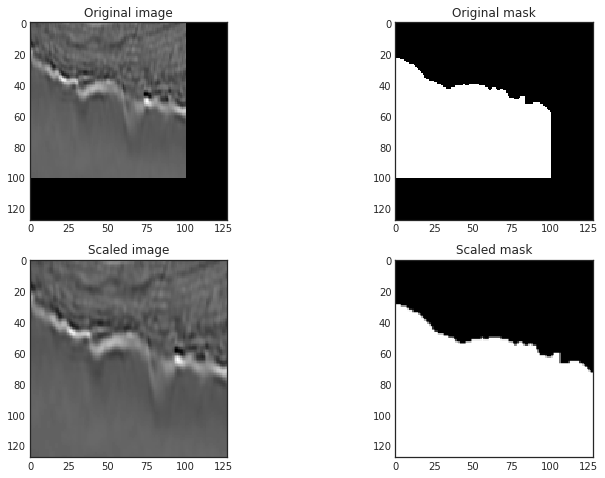

In [14]:
idx = np.random.randint(0,4000)
print(idx)

tmp_img = np.zeros((img_size_target,img_size_target), dtype=np.float64)
tmp_mask = np.zeros((img_size_target,img_size_target), dtype=np.float64)

tmp_img[0:img_size_ori, 0:img_size_ori] = salt_parser.X_train[idx,:,:,0]
tmp_mask[0:img_size_ori, 0:img_size_ori] = salt_parser.y_train[idx,:,:,0]

fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].imshow(tmp_img, cmap="gray")
ax[0,0].set_title("Original image")
ax[0,1].imshow(tmp_mask, cmap="gray")
ax[0,1].set_title("Original mask")
ax[1,0].imshow(X_train_proc[idx].squeeze(), cmap="gray")
ax[1,0].set_title("Scaled image")
ax[1,1].imshow(y_train_proc[idx].squeeze(), cmap="gray")
ax[1,1].set_title("Scaled mask")

# Split Data

In [15]:
# Perform 80/20 training/validation split based on stratified coverage.
X_train, X_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    X_train_proc,
    y_train_proc,
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, 
    stratify=train_df.coverage_class, 
    random_state=777)

X_test = X_test_proc

del train_df
gc.collect()

del X_train_proc, y_train_proc
gc.collect()

0

In [16]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((3200, 128, 128, 1),
 (800, 128, 128, 1),
 (3200, 128, 128, 1),
 (800, 128, 128, 1),
 (18000, 128, 128, 1))

## Remove image with small mask

In [17]:
# # boolean mask for mask with either all black pixel or at least 50 white pixels
thres = 100
y_mask = np.squeeze((y_train.sum(axis=(1,2))>=thres) | (y_train.sum(axis=(1,2))==0))
np.where(~y_mask)

(array([   1,   15,   23,   44,   47,   67,   68,   97,  152,  154,  174,
         216,  222,  269,  313,  342,  367,  405,  424,  474,  475,  477,
         505,  543,  595,  680,  709,  730,  750,  765,  783,  844,  865,
         907,  926,  942,  965,  984,  991, 1004, 1055, 1090, 1143, 1168,
        1209, 1227, 1306, 1323, 1334, 1352, 1384, 1401, 1424, 1472, 1483,
        1510, 1537, 1573, 1582, 1620, 1636, 1769, 1770, 1776, 1873, 1917,
        1935, 1977, 2000, 2059, 2075, 2166, 2193, 2211, 2224, 2239, 2248,
        2306, 2422, 2548, 2580, 2627, 2679, 2691, 2741, 2806, 2821, 2857,
        2876, 2937, 2974, 3017, 3033, 3041, 3046, 3097, 3101, 3156, 3166]),)

In [18]:
np.shape(np.where(~y_mask))

(1, 99)

In [19]:
idx = np.where(~y_mask)[0][-1]
idx

3166

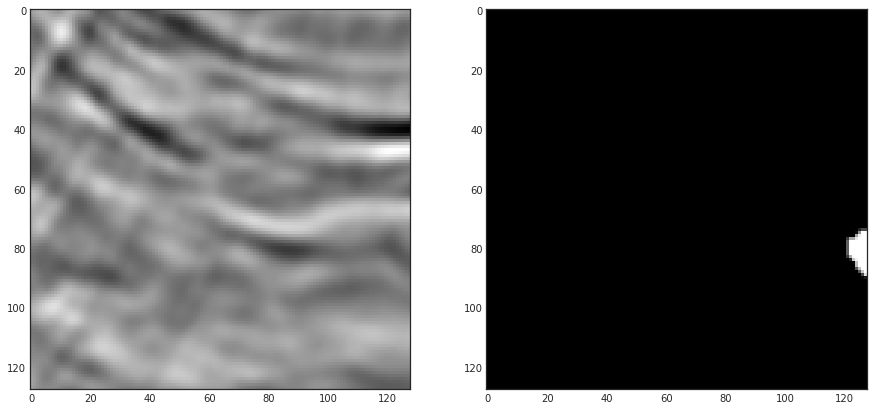

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

ax[0].imshow(X_train[idx].squeeze(), cmap="gray")
ax[1].imshow(y_train[idx].squeeze(), cmap="gray")
plt.show()

In [21]:
len(y_train) - len(y_train[y_mask])

99

In [22]:
X_train.shape, y_train.shape

((3200, 128, 128, 1), (3200, 128, 128, 1))

In [23]:
X_train = X_train[y_mask]
y_train = y_train[y_mask]

In [24]:
X_train.shape, y_train.shape

((3101, 128, 128, 1), (3101, 128, 128, 1))

# Simple horizontal augmentation to double the data

In [25]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

# Expand to three channels since resnet takes RGB by default

In [26]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((6202, 128, 128, 1),
 (800, 128, 128, 1),
 (6202, 128, 128, 1),
 (800, 128, 128, 1),
 (18000, 128, 128, 1))

In [27]:
X_train = np.repeat(X_train,3,axis=3)
X_valid = np.repeat(X_valid,3,axis=3)
X_test = np.repeat(X_test,3,axis=3)

In [28]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((6202, 128, 128, 3),
 (800, 128, 128, 3),
 (6202, 128, 128, 1),
 (800, 128, 128, 1),
 (18000, 128, 128, 3))

# Define UNet model

https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py

In [29]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

def conv_block_simple_no_bn(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

In [30]:
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [31]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [32]:
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

#     x = AveragePooling2D((7, 7), name='avg_pool')(x)

#     if include_top:
#         x = Flatten()(x)
#         x = Dense(classes, activation='softmax', name='fc1000')(x)
#     else:
#         if pooling == 'avg':
#             x = GlobalAveragePooling2D()(x)
#         elif pooling == 'max':
#             x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path,by_name=True)
    return model

In [33]:
K.clear_session()

def get_unet_resnet(input_shape):
    dropout = True
    resnet_base = ResNet50(include_top=False, input_shape=input_shape)

    for l in resnet_base.layers:
        if isinstance(l, keras.layers.normalization.BatchNormalization):
            l.trainable = True
        else:
            l.trainable = False
        
    conv1 = resnet_base.get_layer("activation_1").output
    conv2 = resnet_base.get_layer("activation_10").output
    conv3 = resnet_base.get_layer("activation_22").output
    conv4 = resnet_base.get_layer("activation_40").output
    conv5 = resnet_base.get_layer("activation_49").output
    
    
#     # Middle
#     convm = Conv2D(512, (3,3), activation=None, padding='same')(resnet_base.output)?
#     convm = conv_block_simple(convm, 512, "convm_1")
#     convm = conv_block_simple(convm, 512, "convm_2")
    

    conv6 = concatenate([UpSampling2D()(conv5), conv4], axis=-1)
    if dropout: conv6 = Dropout(0.5)(conv6)
    conv6 = conv_block_simple(conv6, 256, "conv6_1")
    conv6 = conv_block_simple(conv6, 256, "conv6_2")
 
    conv7 = concatenate([UpSampling2D()(conv6), conv3], axis=-1)
    if dropout: conv7 = Dropout(0.5)(conv7)
    conv7 = conv_block_simple(conv7, 192, "conv7_1")
    conv7 = conv_block_simple(conv7, 192, "conv7_2")

    conv8 = concatenate([UpSampling2D()(conv7), conv2], axis=-1)
    if dropout: conv8 = Dropout(0.5)(conv8)
    conv8 = conv_block_simple(conv8, 128, "conv8_1")
    conv8 = conv_block_simple(conv8, 128, "conv8_2")


    conv9 = concatenate([UpSampling2D()(conv8), conv1], axis=-1)
    if dropout: conv9 = Dropout(0.5)(conv9)
    conv9 = conv_block_simple(conv9, 64, "conv9_1")
    conv9 = conv_block_simple(conv9, 64, "conv9_2")

    conv10 = UpSampling2D()(conv9)
    conv10 = conv_block_simple(conv10, 32, "conv10_1")
    conv10 = conv_block_simple(conv10, 32, "conv10_2")
    conv10 = SpatialDropout2D(0.2)(conv10)
    
#     x = Conv2D(1, (1, 1), activation="sigmoid", name="prediction")(conv10)
    
    x = Conv2D(1, (1,1), padding='same', activation=None, name="prediction")(conv10)
    x = Activation('sigmoid')(x)
    
    model = Model(resnet_base.input, x)
    
    return model

# Metric Loss

In [34]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0], tf.float64)

In [35]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [36]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [37]:
def focal_loss(gamma=2., alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-6, 1 - 1e-6)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1. - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), K.ones_like(y_pred) * K.constant(alpha), K.ones_like(y_pred) * K.constant(1. - alpha))
        loss = K.mean(-1. * alpha_t * (1. - p_t)**gamma * K.log(p_t))
        return loss
    return focal_loss_fixed

# Build Model

In [38]:
save_model_nameA = 'unet_V4_3A.model'
save_model_nameB = 'unet_V4_3B.model'
save_model_nameC = 'unet_V4_3C.model'

In [ ]:
img_shape = (img_size_target,img_size_target,3)
model1 = get_unet_resnet(input_shape=img_shape)
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [ ]:
opt = optimizers.Adam(lr=0.01)
model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=[my_iou_metric])

early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode='max', patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameA, monitor='val_my_iou_metric', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=6, min_lr=0.00001, verbose=1)

epochs = 30
batch_size = 32

# model1.compile(loss=bce_dice_loss, optimizer=opt, metrics=[my_iou_metric])
# model1.compile(loss=[focal_loss(alpha=.5, gamma=2)], optimizer=opt, metrics=[my_iou_metric])

# Train model:

In [ ]:
%%time
history = model1.fit(X_train, y_train,
                     validation_data=[X_valid, y_valid], 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     callbacks=[early_stopping, model_checkpoint, reduce_lr],
                     verbose=1)

Train on 6202 samples, validate on 800 samples
Epoch 1/30
6202/6202 [==============================] - 148s 24ms/step - loss: 0.2518 - my_iou_metric: 0.5657 - val_loss: 0.1902 - val_my_iou_metric: 0.6665

Epoch 00001: val_my_iou_metric improved from -inf to 0.66650, saving model to unet_V4_3A.model
Epoch 2/30
6202/6202 [==============================] - 127s 21ms/step - loss: 0.1748 - my_iou_metric: 0.6618 - val_loss: 0.2267 - val_my_iou_metric: 0.7038

Epoch 00002: val_my_iou_metric improved from 0.66650 to 0.70375, saving model to unet_V4_3A.model
Epoch 3/30
6202/6202 [==============================] - 128s 21ms/step - loss: 0.1503 - my_iou_metric: 0.6992 - val_loss: 0.2481 - val_my_iou_metric: 0.7003

Epoch 00003: val_my_iou_metric did not improve from 0.70375
Epoch 4/30
6202/6202 [==============================] - 128s 21ms/step - loss: 0.1281 - my_iou_metric: 0.7451 - val_loss: 0.1548 - val_my_iou_metric: 0.7074

Epoch 00004: val_my_iou_metric improved from 0.70375 to 0.70737, sav

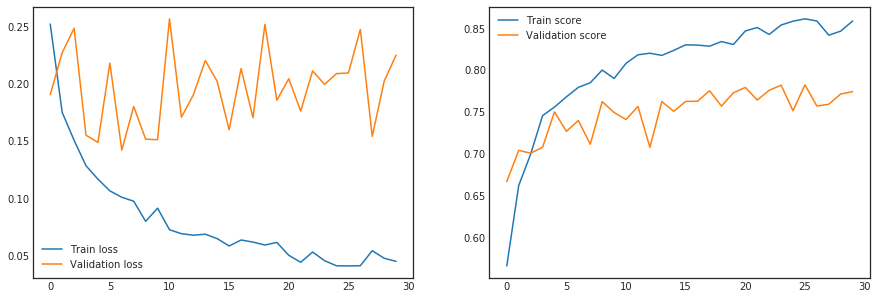

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))

ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()

ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

# Finetune with lovasz_loss

In [ ]:
model1 = load_model(save_model_nameA, custom_objects={'my_iou_metric':my_iou_metric})

input_x = model1.layers[0].input
output_layer = model1.layers[-1].input

model = Model(input_x, output_layer)
opt = optimizers.adam(lr=0.005)

model.compile(loss=lovasz_loss, optimizer=opt, metrics=[my_iou_metric_2])

early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max', factor=0.5, patience=6, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 16

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    validation_data=[X_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint, reduce_lr, early_stopping], 
                    verbose=1)

Train on 6202 samples, validate on 800 samples
Epoch 1/100
6202/6202 [==============================] - 355s 57ms/step - loss: -0.4322 - my_iou_metric_2: 0.8529 - val_loss: 0.0413 - val_my_iou_metric_2: 0.7856

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.78562, saving model to unet_V4_3B.model
Epoch 2/100
6202/6202 [==============================] - 334s 54ms/step - loss: -0.4780 - my_iou_metric_2: 0.8614 - val_loss: -0.0025 - val_my_iou_metric_2: 0.7782

Epoch 00002: val_my_iou_metric_2 did not improve from 0.78562
Epoch 3/100
6202/6202 [==============================] - 334s 54ms/step - loss: -0.5122 - my_iou_metric_2: 0.8659 - val_loss: 0.0664 - val_my_iou_metric_2: 0.7790

Epoch 00003: val_my_iou_metric_2 did not improve from 0.78562
Epoch 4/100
6202/6202 [==============================] - 334s 54ms/step - loss: -0.5234 - my_iou_metric_2: 0.8665 - val_loss: 0.0928 - val_my_iou_metric_2: 0.7710

Epoch 00004: val_my_iou_metric_2 did not improve from 0.78562
Epoch 5/100
6

In [39]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

opt = optimizers.adam(lr=0.001)
model.compile(loss=lovasz_loss, optimizer=opt, metrics=[my_iou_metric_2])

early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameC, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max', factor=0.5, patience=6, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 16

In [40]:
%%time
history = model.fit(X_train, y_train,
                    validation_data=[X_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=1)

Train on 6202 samples, validate on 800 samples
Epoch 1/100
6202/6202 [==============================] - 353s 57ms/step - loss: -0.6854 - my_iou_metric_2: 0.8964 - val_loss: 0.0726 - val_my_iou_metric_2: 0.7970

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.79700, saving model to unet_V4_3C.model
Epoch 2/100
6202/6202 [==============================] - 335s 54ms/step - loss: -0.6934 - my_iou_metric_2: 0.8987 - val_loss: 0.1091 - val_my_iou_metric_2: 0.7912

Epoch 00002: val_my_iou_metric_2 did not improve from 0.79700
Epoch 3/100
6202/6202 [==============================] - 335s 54ms/step - loss: -0.7008 - my_iou_metric_2: 0.9008 - val_loss: 0.1141 - val_my_iou_metric_2: 0.7921

Epoch 00003: val_my_iou_metric_2 did not improve from 0.79700
Epoch 4/100
6202/6202 [==============================] - 334s 54ms/step - loss: -0.7124 - my_iou_metric_2: 0.9017 - val_loss: 0.1292 - val_my_iou_metric_2: 0.7914

Epoch 00004: val_my_iou_metric_2 did not improve from 0.79700
Epoch 5/100
62

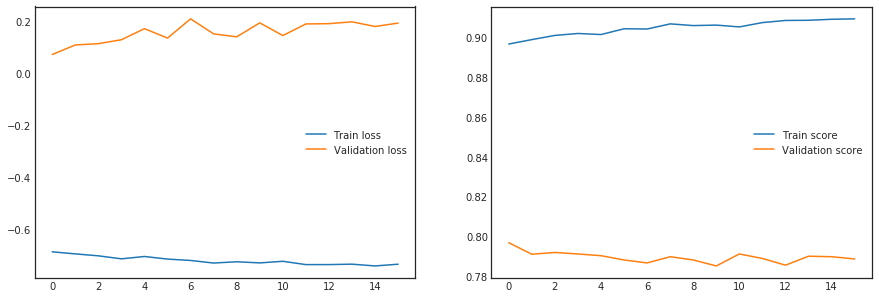

In [41]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [42]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

opt = optimizers.adam(lr=0.001)
model.compile(loss=lovasz_loss, optimizer=opt, metrics=[my_iou_metric_2])

early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameC, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max', factor=0.5, patience=6, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 16

In [43]:
%%time
history = model.fit(X_train, y_train,
                    validation_data=[X_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=1)

Train on 6202 samples, validate on 800 samples
Epoch 1/100
6202/6202 [==============================] - 353s 57ms/step - loss: -0.6838 - my_iou_metric_2: 0.8961 - val_loss: 0.0834 - val_my_iou_metric_2: 0.7896

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.78962, saving model to unet_V4_3C.model
Epoch 2/100
6202/6202 [==============================] - 335s 54ms/step - loss: -0.6972 - my_iou_metric_2: 0.9005 - val_loss: 0.1080 - val_my_iou_metric_2: 0.7877

Epoch 00002: val_my_iou_metric_2 did not improve from 0.78962
Epoch 3/100
6202/6202 [==============================] - 336s 54ms/step - loss: -0.7003 - my_iou_metric_2: 0.9004 - val_loss: 0.0946 - val_my_iou_metric_2: 0.7919

Epoch 00003: val_my_iou_metric_2 improved from 0.78962 to 0.79187, saving model to unet_V4_3C.model
Epoch 4/100
6202/6202 [==============================] - 335s 54ms/step - loss: -0.7069 - my_iou_metric_2: 0.9027 - val_loss: 0.0875 - val_my_iou_metric_2: 0.7949

Epoch 00004: val_my_iou_metric_2 impro

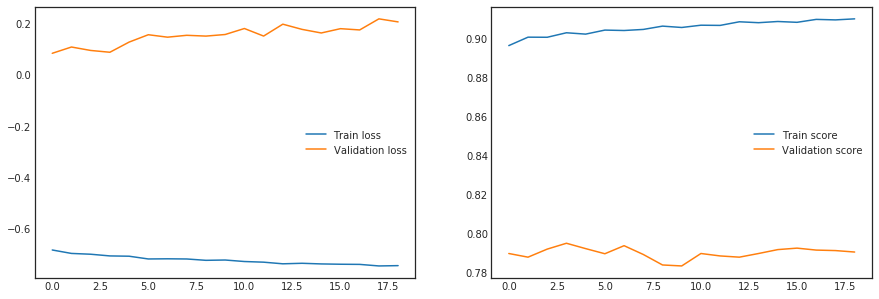

In [44]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

# Predict

In [ ]:
# model = load_model(save_model_name, custom_objects={'my_iou_metric':my_iou_metric})

In [ ]:
model = load_model(save_model_nameC,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [ ]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [ ]:
preds_valid = predict_result(model,X_valid,img_size_target)

In [ ]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

In [ ]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [ ]:
%%time
preds_test = predict_result(model,X_test,img_size_target)

In [ ]:
y_pred_test_rle = salt_parser.predictions_rle_encode(preds_test, 
                                                     confidence_threshold_best=threshold_best)

In [ ]:
submission = salt_parser.generate_submission(y_pred_test_rle)
submission.to_csv('submission_unet_v4-v3.csv')